In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]


In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data', 'derived', 'cleaned_matches.csv')
cleaned_matches = pd.read_csv(data)


In [5]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date', inplace=True, ascending=True)
cleaned_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             26122 non-null  object        
 1   Date            26122 non-null  datetime64[ns]
 2   Home/Away       26122 non-null  object        
 3   Opponent        26122 non-null  object        
 4   Score           26122 non-null  object        
 5   W/L/T           26122 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        26122 non-null  object        
 8   Venue           26122 non-null  object        
 9   Attendance      26098 non-null  float64       
 10  Notes           1061 non-null   object        
 11  Opponent Code   26122 non-null  object        
 12  Team            26122 non-null  object        
 13  Team Code       26122 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

## Train to classify based on the last-n-games a team played

In [6]:
x_cols = [
    'Team Code',
    'Opponent Code'
]
lookup_x_cols = [
    'Team Score',
    'Opponent Score',
    'Opponent Code'
]
y_cols = [
    'Class'
]

played_matches = cleaned_matches.dropna(
    axis=0, how='any', subset=x_cols + y_cols + lookup_x_cols).copy()

played_matches['Class'].where(
    played_matches['Class'] > 0, other=0, inplace=True)
played_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25942 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             25942 non-null  object        
 1   Date            25942 non-null  datetime64[ns]
 2   Home/Away       25942 non-null  object        
 3   Opponent        25942 non-null  object        
 4   Score           25942 non-null  object        
 5   W/L/T           25942 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        25942 non-null  object        
 8   Venue           25942 non-null  object        
 9   Attendance      25918 non-null  float64       
 10  Notes           1051 non-null   object        
 11  Opponent Code   25942 non-null  object        
 12  Team            25942 non-null  object        
 13  Team Code       25942 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

In [7]:
last_n_matches, new_columns = form_last_n_games(
    played_matches, 5, lookup_x_cols, x_cols)

.................................................
 Done


In [8]:
X = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y = last_n_matches[y_cols]

numeric_columns = X.columns[X.columns.str.contains('Score')]
dummies_columns = X.columns[~X.columns.str.contains('Score')]
print(dummies_columns)
print(numeric_columns)

Index(['Team Code', 'Opponent Code', 'Team Code_p_Opponent Code',
       'Opponent Code_p_Opponent Code', 'Team Code_pp_Opponent Code',
       'Opponent Code_pp_Opponent Code', 'Team Code_ppp_Opponent Code',
       'Opponent Code_ppp_Opponent Code', 'Team Code_pppp_Opponent Code',
       'Opponent Code_pppp_Opponent Code', 'Team Code_ppppp_Opponent Code',
       'Opponent Code_ppppp_Opponent Code'],
      dtype='object')
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
       'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
       'Team Code_p_Opponent Score', 'Opponent Code_p_Opponent Score',
       'Team Code_pp_Opponent Score', 'Opponent Code_pp_Opponent Score',
       'Team Code_ppp_Opponent Score', 'Opponent Code_ppp_Opponent Score',
       'Team Code_ppp

In [9]:
X.head()

,Team Code,Opponent Code,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,Opponent Code_pppp_Team Score,...,Team Code_p_Opponent Code,Opponent Code_p_Opponent Code,Team Code_pp_Opponent Code,Opponent Code_pp_Opponent Code,Team Code_ppp_Opponent Code,Opponent Code_ppp_Opponent Code,Team Code_pppp_Opponent Code,Opponent Code_pppp_Opponent Code,Team Code_ppppp_Opponent Code,Opponent Code_ppppp_Opponent Code
12,buf,cle,6.0,6.0,0.0,28.0,21.0,0.0,0.0,0.0,...,buf,buf,buf,cin,det,cle,buf,buf,cle,cle
19,gb,chic,16.0,16.0,3.0,3.0,3.0,3.0,6.0,0.0,...,gb,gb,chic,chic,gb,gb,gb,chic,min,min
23,min,chic,3.0,3.0,6.0,3.0,7.0,16.0,0.0,3.0,...,min,min,gb,chic,min,gb,chic,chic,min,gb
25,chic,buf,0.0,7.0,3.0,0.0,3.0,10.0,16.0,6.0,...,chic,buf,min,chib,chic,cle,gb,buf,chic,buf
24,buf,chic,9.0,9.0,7.0,0.0,0.0,3.0,10.0,3.0,...,buf,buf,buf,chic,chib,min,cle,chic,buf,gb


In [10]:
def dataset_transformer():
    return ColumnTransformer([('scaler', StandardScaler(), numeric_columns), ('one-hot', OneHotEncoder(handle_unknown='ignore'), dummies_columns)])

dataset_transformer().fit(X, y)

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
       'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
       'Team Code_p_Op...
                                 Index(['Team Code', 'Opponent Code', 'Team Code_p_Opponent Code',
       'Opponent Code_p_Opponent Code', 'Team Code_pp_Opponent Code',
       'Opponent Code_pp_Opponent Code', 'Team Code_ppp_Opponent Code',
       'Opponent Code_ppp_Opponent Code', 'Team Code_pppp_Opponent Code',
       'Opponent Code_pppp_Opponent Code', 'Team Code_ppppp_Opponent Code',
       'Opponent Code_ppppp_Opponent Code'],
      dtype='object'))])

In [11]:
X.describe()

,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,Opponent Code_pppp_Team Score,Team Code_ppppp_Team Score,Opponent Code_ppppp_Team Score,Team Code_p_Opponent Score,Opponent Code_p_Opponent Score,Team Code_pp_Opponent Score,Opponent Code_pp_Opponent Score,Team Code_ppp_Opponent Score,Opponent Code_ppp_Opponent Score,Team Code_pppp_Opponent Score,Opponent Code_pppp_Opponent Score,Team Code_ppppp_Opponent Score,Opponent Code_ppppp_Opponent Score
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,7.150000,6.216667,5.683333,7.316667,6.783333,6.033333,4.616667,6.300000,6.966667,5.116667,6.683333,6.683333,7.183333,5.983333,4.666667,7.600000,6.933333,5.416667,4.833333,7.133333
std,6.691317,6.805012,6.895077,6.885238,6.346203,6.686609,6.114977,6.268836,6.550887,6.407336,7.365728,6.796040,6.657458,7.036206,6.331698,7.088305,6.537679,6.641655,5.915125,7.202793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.250000,0.000000,0.000000,3.000000,2.250000,0.000000,0.000000,0.000000
50%,6.000000,4.500000,3.000000,6.000000,6.000000,3.000000,0.000000,4.500000,6.500000,3.000000,3.000000,6.000000,6.000000,3.000000,0.000000,6.000000,6.000000,3.000000,3.000000,6.000000
75%,13.000000,10.500000,10.000000,12.250000,9.250000,13.000000,7.500000,9.250000,10.500000,7.500000,13.250000,10.500000,12.250000,13.000000,7.000000,12.250000,10.000000,9.000000,7.500000,13.000000
max,22.000000,22.000000,22.000000,28.000000,21.000000,21.000000,20.000000,21.000000,21.000000,21.000000,23.000000,23.000000,22.000000,22.000000,22.000000,28.000000,21.000000,21.000000,21.000000,21.000000


In [12]:
y.head()

,Class
12,1
19,0
23,0
25,1
24,0


In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
    X, y, test_pct=0.2, val_pct=0.2, random_state=0
)

# y_train = y_train.ravel()
# y_val = y_val.ravel()
# y_test = y_test.ravel()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(36, 32) (36, 1)
(12, 32) (12, 1)
(12, 32) (12, 1)


In [14]:
# maxima = X_train.max(axis=0)
# minima = X_train.min(axis=0)
# numerical = (maxima > 1) | (minima < 0)

# numerical_columns = X.columns[numerical].to_list()

# mean = np.mean(X_train[:, numerical])
# std = np.std(X_train[:, numerical])

# X_train[:, numerical] = (X_train[:, numerical] - mean) / std
# X_val[:, numerical] = (X_val[:, numerical] - mean) / std
# X_test[:, numerical] = (X_test[:, numerical] - mean) / std

# X_train[:, numerical]



Evaluating linear kernel for C=0.01
Evaluating linear kernel for C=0.31622776601683794
Evaluating linear kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


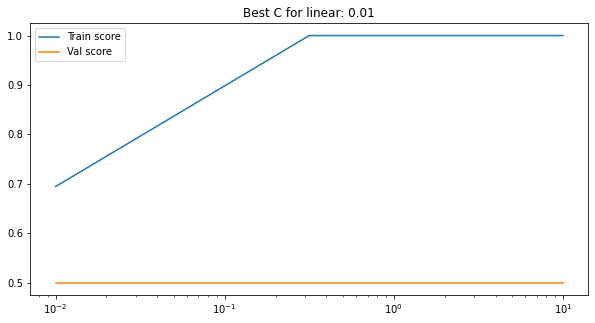

Evaluating poly kernel for C=0.01
Evaluating poly kernel for C=0.31622776601683794
Evaluating poly kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


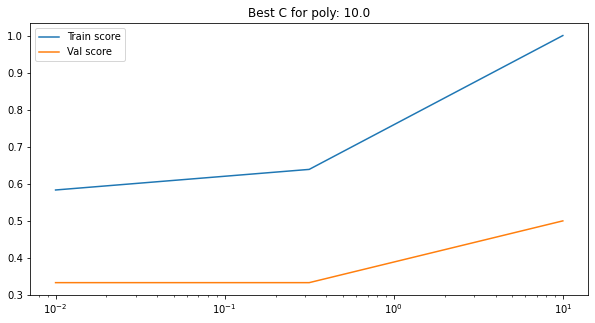

Evaluating rbf kernel for C=0.01
Evaluating rbf kernel for C=0.31622776601683794
Evaluating rbf kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


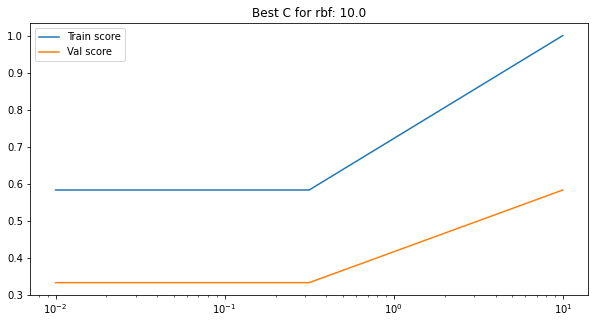

Evaluating sigmoid kernel for C=0.01
Evaluating sigmoid kernel for C=0.31622776601683794
Evaluating sigmoid kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


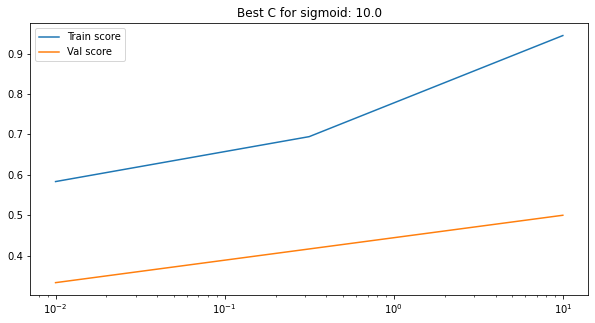

In [15]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    train_scores = []
    val_scores = []
    val_space = np.geomspace(start=0.01, stop=10, num=3)
    for C in val_space:
        print(f"Evaluating {kernel} kernel for C={C}")
        model = make_pipeline(dataset_transformer(), svm.SVC(C=C, max_iter=10_000, kernel=kernel))

        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        val_scores.append(model.score(X_val, y_val))

    plt.title(f'Best C for {kernel}: {val_space[np.argmax(val_scores)]}')
    plt.plot(val_space, train_scores, label='Train score')
    plt.plot(val_space, val_scores, label='Val score')
    # plt.ylim(0, 1.1)
    plt.xscale('log')
    plt.legend()
    plt.show()


In [16]:
y_pred = model.predict(X_test)
precision, recall, fbeta_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

In [17]:
best_config = []
best_score = 0
best_fit_config = []
best_fit_score = 0
for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=62), DecisionTreeClassifier(max_leaf_nodes=124)]:
  for nestimators in [10, 31, 62, 93, 124]:
    for nsamples in [10, 20, 30, 50]:
      clf = make_pipeline(dataset_transformer(), BaggingClassifier(base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples))
      clf.fit(X_train, y_train)
      
      score = clf.score(X_val, y_val)
      if(score > best_score):
        best_config = [estimator, nestimators, nsamples]
        best_score = score
      
      score = clf.score(X_train, y_train)
      if(score > best_fit_score):
        best_fit_config = [estimator, nestimators, nsamples]
        best_fit_score = score
        
      print(end='.')

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


...

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: max_samples must be in (0, n_samples]

In [ ]:
# print(f"Best validation: {best_score}, {best_config}")
# print(f"Best training: {best_fit_score}, {best_fit_config}")

In [ ]:
clf = make_pipeline(dataset_transformer(), DecisionTreeClassifier())
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.5339278790228771

In [ ]:
clf.predict_proba(X_test[0:1])

array([[0., 1.]])

In [ ]:
team_opponent_codes = X.columns[:-(len(lookup_x_cols) + len(new_columns))]
n_team_codes = len(team_opponent_codes) // 2
opponent_codes, team_codes = team_opponent_codes[n_team_codes:], team_opponent_codes[:n_team_codes]
print(n_team_codes)
print(opponent_codes)
print(team_codes)

30
Index(['Team_Code__was', 'Opponent_Code__ari', 'Opponent_Code__atl',
       'Opponent_Code__bal', 'Opponent_Code__buf', 'Opponent_Code__chib',
       'Opponent_Code__chic', 'Opponent_Code__cin', 'Opponent_Code__cle',
       'Opponent_Code__dal', 'Opponent_Code__den', 'Opponent_Code__det',
       'Opponent_Code__gb', 'Opponent_Code__hou', 'Opponent_Code__ind',
       'Opponent_Code__kc', 'Opponent_Code__larm', 'Opponent_Code__mia',
       'Opponent_Code__min', 'Opponent_Code__ne', 'Opponent_Code__no',
       'Opponent_Code__nyg', 'Opponent_Code__nyj', 'Opponent_Code__oak',
       'Opponent_Code__phi', 'Opponent_Code__pit', 'Opponent_Code__sd',
       'Opponent_Code__sea', 'Opponent_Code__sf', 'Opponent_Code__stl'],
      dtype='object')
Index(['Team_Code__ari', 'Team_Code__atl', 'Team_Code__bal', 'Team_Code__buf',
       'Team_Code__chib', 'Team_Code__chic', 'Team_Code__cin',
       'Team_Code__cle', 'Team_Code__dal', 'Team_Code__den', 'Team_Code__det',
       'Team_Code__gb', 'Team_

In [ ]:
teams = X[team_codes]
opponents = X[opponent_codes]

codes = team_codes.str.split('__')
teams.columns = [code[1] for code in codes]

codes = opponent_codes.str.split('__')
opponents.columns = [code[1] for code in codes]

<AxesSubplot:>

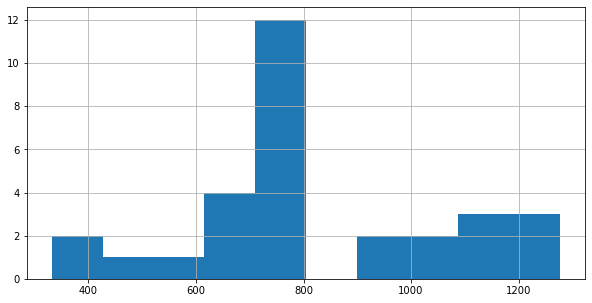

In [ ]:
teams.sum(axis=0).hist()

<AxesSubplot:>

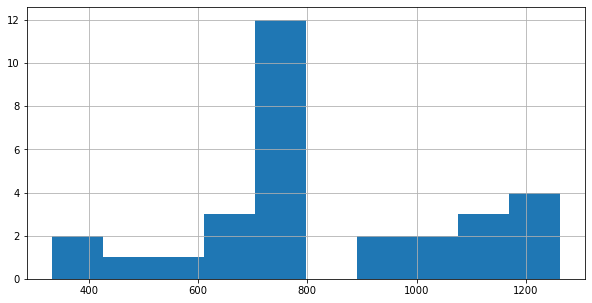

In [ ]:
opponents.sum(axis=0).hist()

<AxesSubplot:>

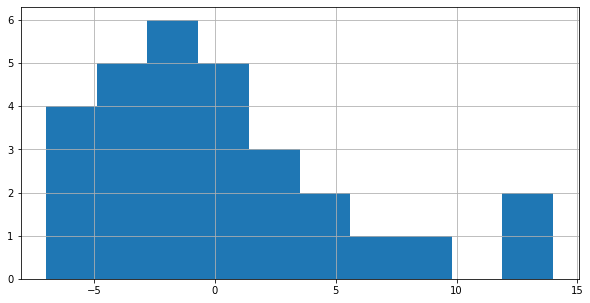

In [ ]:
(teams.sum(axis=0) - opponents.sum(axis=0)).hist()

In [ ]:
unique_teams = X.groupby(team_opponent_codes.to_list()).size().reset_index(name="Count").sort_values('Count').reset_index(drop=True)

In [ ]:
unique_teams

,Team_Code__ari,Team_Code__atl,Team_Code__bal,Team_Code__buf,Team_Code__chib,Team_Code__chic,Team_Code__cin,Team_Code__cle,Team_Code__dal,Team_Code__den,...,Opponent_Code__nyg,Opponent_Code__nyj,Opponent_Code__oak,Opponent_Code__phi,Opponent_Code__pit,Opponent_Code__sd,Opponent_Code__sea,Opponent_Code__sf,Opponent_Code__stl,Count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,176
873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,183
874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,188
875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,196


In [ ]:
for _, row in unique_teams.iterrows():
    mask = row > 0
    elements = row[mask]
    print(' '.join([elem.split('__')[1] for elem in elements.index[:-1]]), elements[-1])


ne ne 1.0
stl chic 1.0
kc kc 1.0
no no 1.0
sea chic 1.0
tb chic 1.0
sd chic 1.0
sf chic 2.0
kc chic 2.0
chic sf 2.0
chic kc 2.0
ind larm 3.0
larm ind 3.0
buf chic 3.0
cin chic 3.0
larm oak 4.0
oak larm 4.0
chic buf 4.0
chic cin 4.0
ind ari 5.0
buf ari 5.0
ari nyj 5.0
larm kc 5.0
kc larm 5.0
ind stl 5.0
chic min 5.0
ari ind 5.0
ari hou 5.0
hou ari 5.0
sd larm 5.0
ari buf 5.0
nyj ari 5.0
stl ind 6.0
stl oak 6.0
oak stl 6.0
ari mia 6.0
min chic 6.0
ne ari 6.0
ari ne 6.0
larm sd 6.0
ari cle 6.0
mia ari 6.0
den ari 7.0
hou stl 7.0
oak ari 7.0
ind min 7.0
stl hou 7.0
larm buf 7.0
cle ari 7.0
bal ari 7.0
tb bal 7.0
sd ari 7.0
buf larm 7.0
min ind 7.0
mia larm 7.0
ari den 7.0
ari bal 7.0
ari sd 7.0
ari oak 7.0
larm mia 7.0
larm ne 8.0
larm nyj 8.0
nyg ind 8.0
den stl 8.0
kc ari 8.0
ind nyg 8.0
ind det 8.0
nyj larm 8.0
ne larm 8.0
ari pit 8.0
cin ari 8.0
ari kc 8.0
hou larm 8.0
sea bal 8.0
sd stl 8.0
cin larm 8.0
ari cin 8.0
phi kc 8.0
pit ari 8.0
det ind 8.0
den larm 8.0
ari larm 8.0
bal sea 8

In [ ]:
X_cv = np.concatenate([X_train, X_val])
y_cv = np.concatenate([y_train, y_val])

In [ ]:
Cs = np.geomspace(0.01, 15, num=75)
scores = []
for c in Cs:
    model = make_pipeline(dataset_transformer(), svm.LinearSVC(dual=False, C=c, max_iter=100_000))
    scores.append(cross_val_score(
        model, X_cv, y_cv, cv=5))
    print(end='.')


...........................................................................

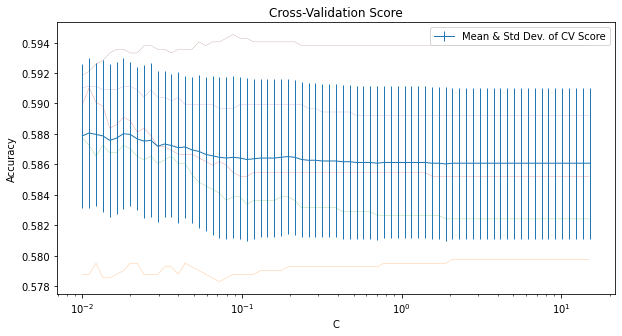

In [ ]:
x = Cs
plt.errorbar(x, np.mean(scores,axis=1), np.std(scores,axis=1), label='Mean & Std Dev. of CV Score', linewidth=1)
plt.plot(x, np.sort(scores, axis=1), linewidth=0.2)
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Score')
plt.show()

In [ ]:
print('Maximum mean:', np.max(np.mean(scores,axis=1)))
print('Corresponding std deviation:', np.std(scores,axis=1)[np.argmax(np.mean(scores,axis=1))])
print('C:',Cs[np.argmax(np.mean(scores,axis=1))])

Maximum mean: 0.5880557940040247
Corresponding std deviation: 0.00493024991070521
C: 0.011038756465634198


In [ ]:
print('Minimum std deviation:', np.min(np.std(scores,axis=1)))
print('Corresponding mean:', np.mean(scores,axis=1)[np.argmin(np.std(scores,axis=1))])
print('C:',Cs[np.argmin(np.std(scores,axis=1))])

Minimum std deviation: 0.004662823924698064
Corresponding mean: 0.5871345936338666
C: 0.04403543412824769


In [ ]:
best_mean_cs = np.flip(np.argsort(np.mean(scores,axis=1)))
best_std_cs = np.argsort(np.std(scores,axis=1))

In [ ]:
# Do some random perturbation of the Cs
scores = []

Cs_to_examine = np.unique(np.concatenate(
    (Cs[best_mean_cs[:5]], Cs[best_std_cs[:5]])))
Cs_to_examine = np.unique(np.concatenate([Cs_to_examine, np.abs(Cs_to_examine + np.random.normal(scale=0.2,size=len(Cs_to_examine)))]))

for c in Cs_to_examine:
    model = make_pipeline(dataset_transformer(), svm.LinearSVC(dual=False, C=c, max_iter=100_000))
    
    scores.append(cross_val_score(
        model, X_cv, y_cv, cv=100))
    
    print(end='.')

................

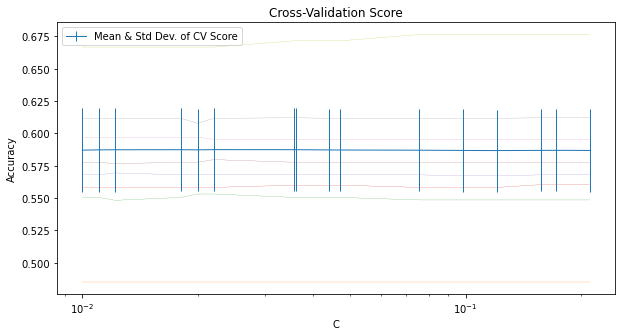

In [ ]:
x = Cs_to_examine
quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
plt.errorbar(x, np.mean(scores,axis=1), np.std(scores,axis=1), label='Mean & Std Dev. of CV Score', linewidth=1)
plt.plot(x, np.quantile(scores, quantiles, axis=1).T, linewidth=0.2)
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Score')
plt.show()

In [ ]:
best_mean_idx = np.argmax(np.mean(scores,axis=1))

print(f'Best C={Cs_to_examine[best_mean_idx]} with mean={np.mean(scores,axis=1)[best_mean_idx]}, std={np.std(scores,axis=1)[best_mean_idx]}')

Best C=0.022047594725960542 with mean=0.587426949955443, std=0.032180881787355946


In [ ]:
# Train the best model.

model = make_pipeline(dataset_transformer(),
    svm.LinearSVC(dual=False, C=Cs_to_examine[best_mean_idx], max_iter=100_000))
model.fit(X_cv, y_cv)
model.score(X_test, y_test)

0.5835595191934858

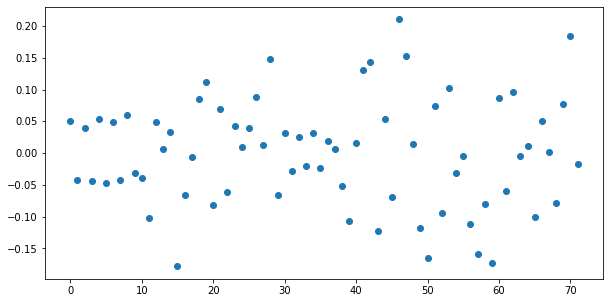

In [ ]:
coefs = model[1].coef_[0]
plt.scatter(x=np.arange(len(coefs)),y=coefs)
plt.show()

In [ ]:
model.fit(X.to_numpy(), y.to_numpy().ravel())
confidences = model.decision_function(X.to_numpy())

(array([1.000e+00, 1.000e+00, 8.000e+00, 1.600e+01, 9.700e+01, 2.490e+02,
        5.000e+02, 9.710e+02, 1.607e+03, 2.305e+03, 3.021e+03, 3.457e+03,
        3.544e+03, 3.190e+03, 2.540e+03, 1.901e+03, 1.168e+03, 6.580e+02,
        3.470e+02, 1.290e+02, 6.500e+01, 9.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00]),
 array([-0.95896284, -0.88116613, -0.80336942, -0.7255727 , -0.64777599,
        -0.56997928, -0.49218257, -0.41438586, -0.33658915, -0.25879244,
        -0.18099573, -0.10319902, -0.02540231,  0.0523944 ,  0.13019112,
         0.20798783,  0.28578454,  0.36358125,  0.44137796,  0.51917467,
         0.59697138,  0.67476809,  0.7525648 ,  0.83036151,  0.90815822,
         0.98595494]),
 <BarContainer object of 25 artists>)

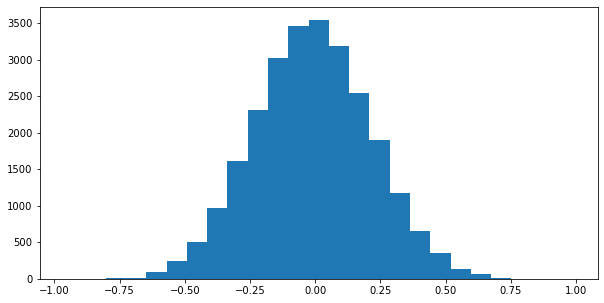

In [ ]:
plt.hist(confidences, bins=25)

(array([4.000e+00, 1.200e+01, 5.200e+01, 9.900e+01, 2.030e+02, 4.180e+02,
        7.520e+02, 1.296e+03, 1.890e+03, 2.534e+03, 3.076e+03, 3.280e+03,
        3.158e+03, 2.954e+03, 2.232e+03, 1.674e+03, 1.041e+03, 6.100e+02,
        3.170e+02, 1.290e+02, 4.300e+01, 9.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00]),
 array([-0.78329397, -0.71252401, -0.64175405, -0.5709841 , -0.50021414,
        -0.42944419, -0.35867423, -0.28790427, -0.21713432, -0.14636436,
        -0.07559441, -0.00482445,  0.06594551,  0.13671546,  0.20748542,
         0.27825537,  0.34902533,  0.41979529,  0.49056524,  0.5613352 ,
         0.63210516,  0.70287511,  0.77364507,  0.84441502,  0.91518498,
         0.98595494]),
 <BarContainer object of 25 artists>)

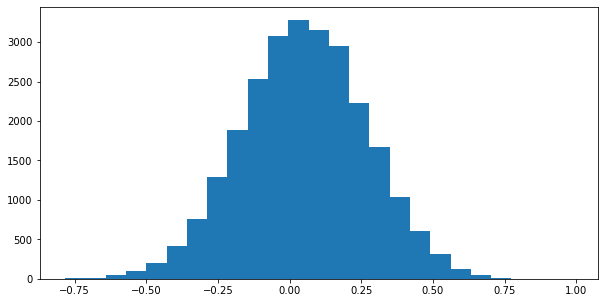

In [ ]:
plt.hist(confidences * (2 * y.to_numpy().ravel() - 1), bins=25)